In [6]:
import random
from collections import deque
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [0]:
env = gym.make('CartPole-v0')

In [0]:
#build the network
input_size = env.observation_space.shape[0]
input_placeholder = tf.placeholder("float", [None, input_size])

In [0]:
#weights and bias of the hidden layer
weights_1 = tf.Variable(tf.truncated_normal([input_size,20],stddev=0.01))
bias_1 = tf.Variable(tf.constant(0.0,shape=[20]))

In [0]:
#weights and bias of the output layer
weights_2 = tf.Variable(tf.truncated_normal([20, env.action_space.n], stddev=0.01))
bias_2 = tf.Variable(tf.constant(0.0,shape=[env.action_space.n]))

In [0]:
hidden_layer = tf.nn.tanh(tf.matmul(input_placeholder,weights_1)+bias_1)
output_layer = tf.matmul(hidden_layer,weights_2) + bias_2

In [0]:
action_placeholder = tf.placeholder("float",[None,2])
target_placeholder = tf.placeholder("float",[None])

In [0]:
#network estimation
q_estimation = tf.reduce_sum(tf.multiply(output_layer,action_placeholder),reduction_indices=1)

In [0]:
#loss function
loss = tf.reduce_mean(tf.square(target_placeholder - q_estimation))

#use adam
train_operation = tf.train.AdamOptimizer().minimize(loss)

# initialize TF variables
session = tf.Session()
session.run(tf.global_variables_initializer())

In [0]:
def choose_next_action(state,rand_action_prob):
  new_action = np.zeros([env.action_space.n])
  if random.random() <= rand_action_prob:
    action_index = random.randrange(env.action_space.n)
  else:
    action_values = session.run(output_layer,feed_dict={input_placeholder:[state]})[0]
    action_index = np.argmax(action_values)
  new_action[action_index] = 1
  return new_action

In [0]:
def train(mini_batch):
  last_state,last_action, reward,current_state, terminal = range(5)
  previous_states = [d[last_state] for d in mini_batch]
  actions = [d[last_action]for d in mini_batch]
  rewards = [d[reward]for d in mini_batch]
  current_states = [d[current_state] for d in mini_batch]
  agents_expected_reward = []
  agents_reward_per_action = session.run(output_layer,
                                         feed_dict={input_placeholder:current_states})
  for i in range(len(mini_batch)):
    if mini_batch[i][terminal]:
      agents_expected_reward.append(rewards[i])
    else:
      discount_factor  =0.9
      agents_expected_reward.append(
          rewards[i] + discount_factor * np.max(agents_reward_per_action[i]))
  session.run(train_operation,feed_dict={
      input_placeholder : previous_states,
      action_placeholder:actions,
      target_placeholder:agents_expected_reward
  })

In [0]:
def q_learning():
  episode_lengths = list()
  observations = deque(maxlen=200000)
  last_action = np.zeros(env.action_space.n)
  last_action[1]= 1
  last_state = env.reset()

  total_reward = 0
  episode = 1
  time_step = 0
  rand_action_prob = 1.0

  while episode <=400:
    last_action = choose_next_action(last_state,rand_action_prob)
    current_state,reward,terminal,info = env.step(np.argmax(last_action))
    total_reward +=reward

    if terminal:
      reward =-1
      episode_lengths.append(time_step)
      print("Episode:%s; Steps before fail: %s; Epsilon: %.2f reward %s"%
            (episode, time_step,rand_action_prob,total_reward))
      total_reward= 0
    observations.append((last_state,last_action,reward,current_state,terminal))
    min_experience_replay_size = 5000
    if len(observations) >min_experience_replay_size:
      mini_batch = random.sample(observations,128)
      train(mini_batch)
      time_step +=1

    if terminal:
      last_state = env.reset()
      time_step = 0
      episode +=1
    else:
      last_state = current_state
    if rand_action_prob >0 and len(observations) > min_experience_replay_size:
      rand_action_prob -= 1.0/15000
  plt.xlabel("Episode")
  plt.ylabel("Length (steps)")
  plt.plot(episode_lengths,label='Episode length')
  plt.show()


Episode:1; Steps before fail: 0; Epsilon: 1.00 reward 15.0
Episode:2; Steps before fail: 0; Epsilon: 1.00 reward 12.0
Episode:3; Steps before fail: 0; Epsilon: 1.00 reward 9.0
Episode:4; Steps before fail: 0; Epsilon: 1.00 reward 15.0
Episode:5; Steps before fail: 0; Epsilon: 1.00 reward 9.0
Episode:6; Steps before fail: 0; Epsilon: 1.00 reward 19.0
Episode:7; Steps before fail: 0; Epsilon: 1.00 reward 31.0
Episode:8; Steps before fail: 0; Epsilon: 1.00 reward 13.0
Episode:9; Steps before fail: 0; Epsilon: 1.00 reward 14.0
Episode:10; Steps before fail: 0; Epsilon: 1.00 reward 10.0
Episode:11; Steps before fail: 0; Epsilon: 1.00 reward 24.0
Episode:12; Steps before fail: 0; Epsilon: 1.00 reward 22.0
Episode:13; Steps before fail: 0; Epsilon: 1.00 reward 19.0
Episode:14; Steps before fail: 0; Epsilon: 1.00 reward 21.0
Episode:15; Steps before fail: 0; Epsilon: 1.00 reward 21.0
Episode:16; Steps before fail: 0; Epsilon: 1.00 reward 22.0
Episode:17; Steps before fail: 0; Epsilon: 1.00 rew

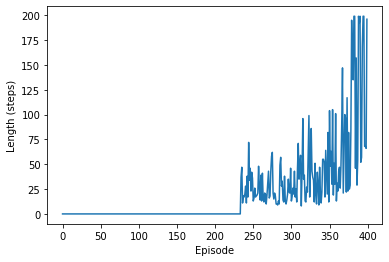

In [27]:
q_learning()